## Scenario 1

Non-age structured model with b~=0

* training data: (samples of) WF model with $b\in[-0.001,0.0006]$
* observed data: samples (n=50,100,500,1000,2000) from WF model with specific $b_i$ values 
* outcome: 1-P(neutral)

We plot the $b_i$ values on the x-axis and the 1-P(neutral ) on the y-axis and compare this to the rejection probability obtained from the Ewens-Watterson test.

TODO:
1. Check max q order: is there still information left?
2. Check distance metric.
3. Check min warmup iterations

In [1]:
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

In [2]:
%run ../src/dataset.py
%run ../src/augmentation.py
%run ../src/simulation.py
%run ../src/utils.py

In [452]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

models = {}

for n in (100, 500, 1000, 2000):
    transform = Compose(Sampler(n=n), HillNumbers(q_step=0.25))
    data = PresimulatedDataset.load(
        "../data/scenario-1-trainset.npz", transform=transform)
    X, theta = data.dataset, data.theta
    X_train, X_dev, theta_train, theta_dev = train_test_split(
        X, theta, test_size=0.2, shuffle=True)
    y_train = (theta_train[:, 0].numpy() != 0).astype(int)
    y_dev = (theta_dev[:, 0].numpy() != 0).astype(int)
    
    clf = RandomForestClassifier(n_jobs=10)
    clf.fit(X_train, y_train)

    probs = clf.predict_proba(X_dev)[:, 1]
    score = roc_auc_score(y_dev, probs)
    
    models[n] = {
        "clf": clf,
        "dev score": score
    }

In [453]:
models

{100: {'clf': RandomForestClassifier(n_jobs=10),
  'dev score': 0.9320004020325646},
 500: {'clf': RandomForestClassifier(n_jobs=10),
  'dev score': 0.95679571129266},
 1000: {'clf': RandomForestClassifier(n_jobs=10),
  'dev score': 0.9627925697489788},
 2000: {'clf': RandomForestClassifier(n_jobs=10),
  'dev score': 0.9653776696883289}}

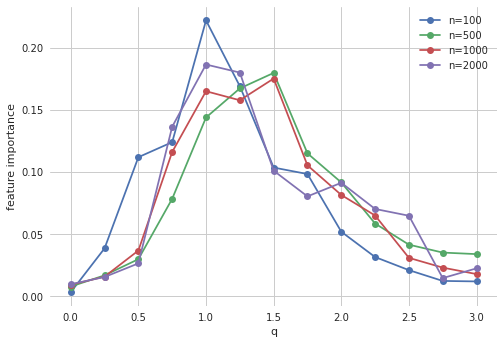

In [454]:
fig, ax = plt.subplots()

q_values = np.arange(0, 3.25, 0.25)

for i, n in enumerate((100, 500, 1000, 2000)):
    ax.plot(q_values, models[n]["clf"].feature_importances_, '-o', color=f"C{i}", label=f"n={n}")
ax.set(xlabel="q", ylabel="feature importance")
plt.legend()

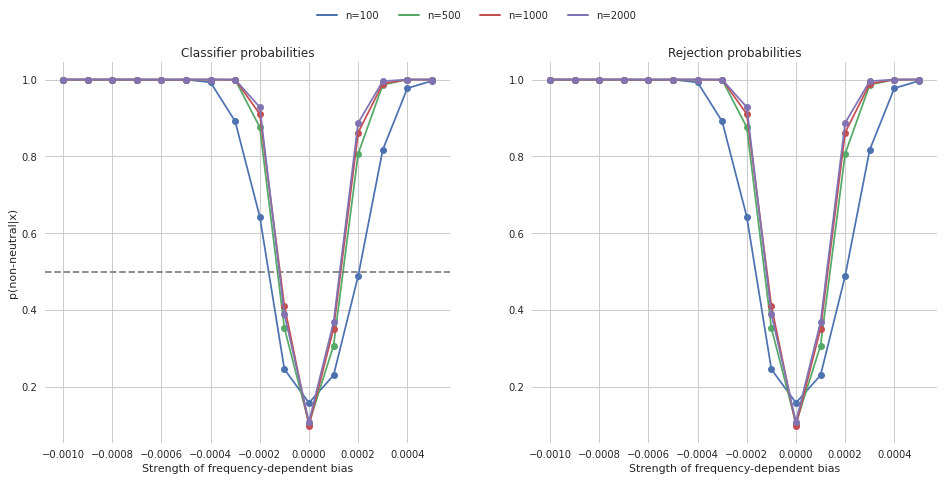

In [466]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(ncols=2, figsize=(16, 7))

for i, n in enumerate((100, 500, 1000, 2000)):
    transform = Compose(Sampler(n=n), HillNumbers(q_step=0.25))
    testdata = PresimulatedDataset.load(
        "../data/scenario-1-testset.npz", transform=transform)

    X_test, theta_test = testdata.dataset, testdata.theta
    y_test = (theta_test[:, 0].numpy() != 0).astype(int)
    
    probs = models[n]["clf"].predict_proba(X_test)[:, 1]
    pred = (probs > 0.5).astype(float)
    score = roc_auc_score(y_test, probs)
    
    df = pd.DataFrame(theta_test.numpy(), columns=["b", "p_mut", "p_death", "age_max"])
    df["prob"] = probs
    df["pred"] = pred
    for l, label in enumerate(("prob", "pred")):
        d = df.groupby("b")["prob"].mean()
        values, labels= d.values, d.index
        axes[l].plot(labels, values, '-o', color=f"C{i}", label=f"n={n}")    
    
axes[0].set(
    ylabel="p(non-neutral|x)", 
    xlabel="Strength of frequency-dependent bias", 
    title="Classifier probabilities"
)

axes[1].set(
    xlabel="Strength of frequency-dependent bias",
    title="Rejection probabilities"
)

custom_lines = [Line2D([0], [0], color="C0", lw=2),
                Line2D([0], [0], color="C1", lw=2),
                Line2D([0], [0], color="C2", lw=2),
                Line2D([0], [0], color="C3", lw=2)]
fig.legend(custom_lines, ['n=100', 'n=500', 'n=1000', 'n=2000'], 
          loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.0), frameon=False)

axes[0].axhline(0.5, ls="--", color="grey");

plt.savefig("../plots/scenario1.png", 
            transparent=True, dpi=300, bbox_inches='tight')

## Scenario 2

age-structured model with b=0

* training data: (samples of) age-structured model with copyThresholdHigh $\in [2,\ldots,\text{All}]$ and pDeath $\in [0.02, 0.1]$
* observed data: samples (n=50,100,500,1000,2000) from age-structured model with specific $\text{copyThresholdHigh}_i$ values and $\text{pDeath}_i$ values
*outcome: 1-P(neutral)

As before plot the $\text{copyThresholdHigh}_i$  values on the x-axis and the 1-P(neutral) on the y-axis compare this to the rejection probability obtained from the Ewens-Watterson test (or even 3d plot with copyThresholdHigh_i values and $\text{pDeath}_i$ values on x and y axis)

In [432]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = list(range(200, 2000, 200))
max_features = ['auto', 'sqrt']
max_depth = list(range(10, 110, 10)) + [None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=random_grid, 
    n_iter=100, 
    cv=3, 
    verbose=2, 
    random_state=42, 
    n_jobs=30
)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=30,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800]},
                   random_state=42, verbose=2)

In [433]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [508]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

models_2 = {}

for n in (100, 500, 1000, 2000):
    transform = Compose(Sampler(n=n), HillNumbers(q_step=0.25))
    data = PresimulatedDataset.load(
        "../data/scenario-2-large-trainset.npz", transform=transform)
    X, theta = data.dataset.numpy(), data.theta.numpy()
        
#     index = (theta[:, 0] >= -0.001) & (theta[:, 0] <= 0.0005)
#     X, theta = X[index], theta[index]
        
    X_train, X_dev, theta_train, theta_dev = train_test_split(
        X, theta, test_size=0.1, shuffle=True)
    y_train = (theta_train[:, 0] != 0).astype(int)
    y_dev = (theta_dev[:, 0] != 0).astype(int)
        
    clf = RandomForestClassifier(n_jobs=10, **rf_random.best_params_)

    clf.fit(X_train, y_train)

    probs = clf.predict_proba(X_dev)[:, 1]
    score = roc_auc_score(y_dev, probs)
    print(score)
    
    models_2[n] = {
        "clf": clf,
        "dev score": score,
        "scaler": scaler
    }

0.8858671899299815
0.8980693219823654
0.8839257850009603
0.8934013505358007


In [509]:
models_2

{100: {'clf': RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                         n_estimators=1400, n_jobs=10),
  'dev score': 0.8858671899299815,
  'scaler': StandardScaler()},
 500: {'clf': RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                         n_estimators=1400, n_jobs=10),
  'dev score': 0.8980693219823654,
  'scaler': StandardScaler()},
 1000: {'clf': RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                         n_estimators=1400, n_jobs=10),
  'dev score': 0.8839257850009603,
  'scaler': StandardScaler()},
 2000: {'clf': RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                         n_estimators=1400, n_jobs=10),
  'dev score': 0.8934013505358007,
  'scaler': StandardScaler()}}

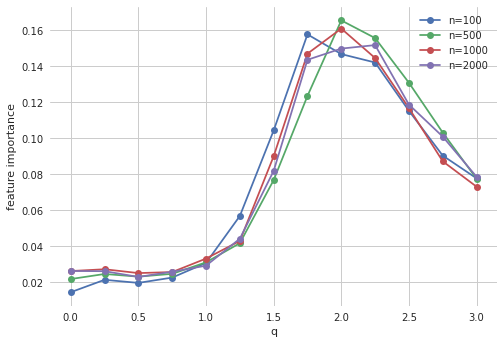

In [510]:
fig, ax = plt.subplots()

q_values = np.arange(0, 3.25, 0.25)

for i, n in enumerate((100, 500, 1000, 2000)):
    ax.plot(q_values, models_2[n]["clf"].feature_importances_, '-o', color=f"C{i}", label=f"n={n}")
ax.set(xlabel="q", ylabel="feature importance")
plt.legend()

In [527]:
theta_train[np.isclose(theta_train[:, 2], 0.02, rtol=1e-2)]

array([[ 1.1567713e-03,  5.0000002e-04,  2.0190328e-02,  1.0000000e+01],
       [ 0.0000000e+00,  5.0000002e-04,  2.0118102e-02,  9.0000000e+00],
       [ 1.0045009e-03,  5.0000002e-04,  2.0105809e-02,  2.0000000e+01],
       [ 5.8031006e-04,  5.0000002e-04,  2.0162182e-02,  1.8000000e+01],
       [ 8.7729405e-04,  5.0000002e-04,  2.0042973e-02,  1.3000000e+01],
       [ 0.0000000e+00,  5.0000002e-04,  2.0025482e-02,  7.0000000e+00],
       [ 0.0000000e+00,  5.0000002e-04,  2.0004924e-02,  3.0000000e+00],
       [ 0.0000000e+00,  5.0000002e-04,  2.0064354e-02,  2.0000000e+01],
       [-1.2392630e-03,  5.0000002e-04,  2.0091357e-02,  2.0000000e+01],
       [ 9.8298036e-04,  5.0000002e-04,  2.0137634e-02,  5.0000000e+00],
       [ 0.0000000e+00,  5.0000002e-04,  2.0192703e-02,  1.0000000e+01],
       [ 9.7759417e-04,  5.0000002e-04,  2.0052623e-02,  1.9000000e+01],
       [ 0.0000000e+00,  5.0000002e-04,  2.0085964e-02,  3.0000000e+00],
       [ 0.0000000e+00,  5.0000002e-04,  2.0098729e

<AxesSubplot:ylabel='Count'>

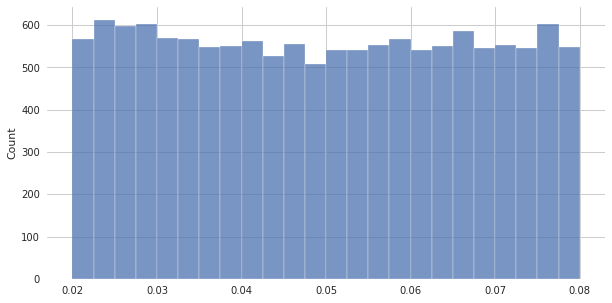

In [537]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(theta_train[np.isclose(theta_train[:, 2], 0.04, rtol=1), 2], ax=ax)

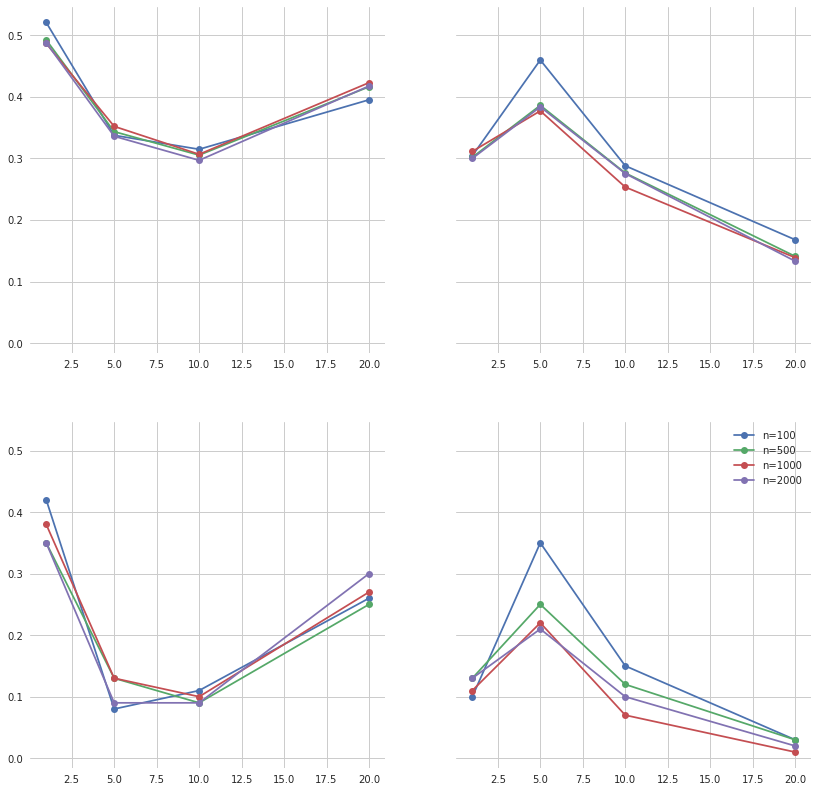

In [511]:
import pandas as pd

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14, 14), sharey=True)
# axes = axes.flatten()

for j, n in enumerate((100, 500, 1000, 2000)):
    transform = Compose(Sampler(n=n), HillNumbers(q_step=0.25))
    testdata = PresimulatedDataset.load(
        "../data/scenario-2-testset.npz", transform=transform)

    for i, p_death in enumerate((0.02, 0.1)):

        X_test, theta_test = testdata.dataset.numpy(), testdata.theta.numpy()
        y_test = (theta_test[:, 0] != 0).astype(int)
        
        index = (theta_test[:, 0] == 0.0) & (theta_test[:, 2] == p_death)
        
        X_test, y_test = X_test[index], y_test[index]
        
        probs = models_2[n]["clf"].predict_proba(X_test)[:, 1]
        pred = (probs > 0.5).astype(float)

        df = pd.DataFrame(theta_test[index], columns=["b", "p_mut", "p_death", "age_max"])
        df["probs"] = probs
        df["pred"] = pred
        for l, label in enumerate(("probs", "pred")):
            d = df.groupby("age_max")[label].mean()
            values, labels = d.values, d.index
            axes[l, i].plot(labels, values, '-o', color=f"C{j}", label=f"n={n}")
    
#         axes[i].set(ylabel="p(non-neutral|x)", xlabel="Age Threshold High");
#         axes[i].axhline(0.5, ls="--", color="grey")
plt.legend();

## Scenario 3

age-structured model with $b \approx 0$

* training data: (samples of) age-structured model with copyThresholdHigh $\in[2,…,All]$ and pDeath $\in [0.02,0.1]$ and $b \in[-0.001,0.0006]$
* observed data: samples (n=50,100,500,1000,2000) from age-structured model with specific copyThresholdHigh_i values and pDeath_i values and $b_i$ values
* outcome: 1-P(neutral)

Now it probably needs to become a 3d plot with $b_i$ and copyThreshold on x- and y-axis?

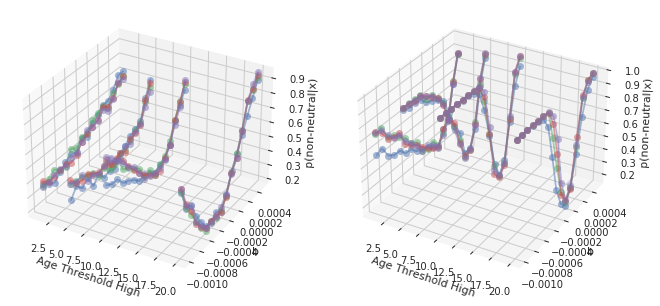

In [150]:
import pandas as pd

fig = plt.figure(figsize=(14, 7))
axes = (
    fig.add_subplot(1, 2, 1, projection='3d'), 
    fig.add_subplot(1, 2, 2, projection='3d')
)

for j, n in enumerate((100, 500, 1000, 2000)):
    transform = Compose(Sampler(n=n), HillNumbers(q_step=0.25))
    testdata = PresimulatedDataset.load(
        "../data/scenario-2-testset.npz", transform=transform)

    for i, p_death in enumerate((0.02, 0.1)):

        X_test, theta_test = testdata.dataset.numpy(), testdata.theta.numpy()
        y_test = (theta_test[:, 0] != 0).astype(int)
        
        index = (theta_test[:, 2] == p_death)
        
        X_test, y_test = X_test[index], y_test[index]

        probs = models_2[n]["clf"].predict_proba(X_test)[:, 1]

        df = pd.DataFrame(theta_test[index], columns=["b", "p_mut", "p_death", "age_max"])
        df["pred"] = probs
        for age, g in df.groupby("age_max"):
            g = g.groupby("b")["pred"].mean()
            b = g.index
            values = g.values
            axes[i].plot([age]*len(b), b, values, '-o', color=f"C{j}", alpha=0.5)
    
        axes[i].set(zlabel="p(non-neutral|x)", xlabel="Age Threshold High", ylabel="b");

The 3d plots are a little hard to read. Let's try a facetted plot:

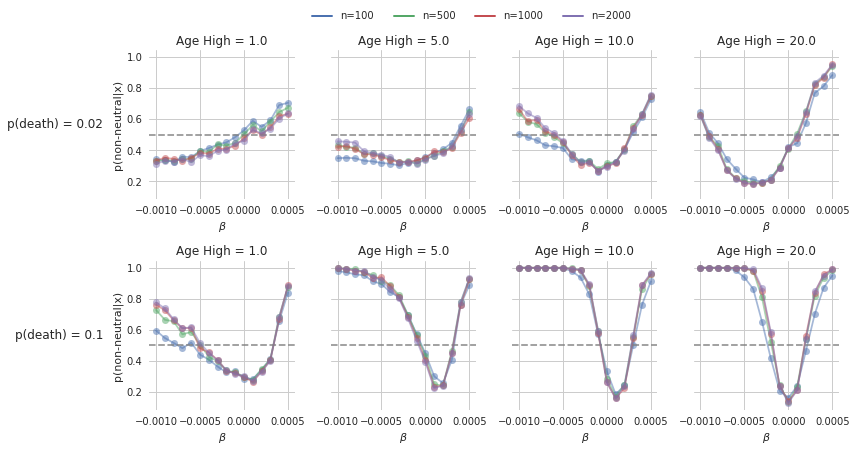

In [482]:
import pandas as pd


fig, axes = plt.subplots(ncols=4, nrows=2, sharey=True, figsize=(12, 6))

for j, n in enumerate((100, 500, 1000, 2000)):
    transform = Compose(Sampler(n=n), HillNumbers(q_step=0.25))
    testdata = PresimulatedDataset.load(
        "../data/scenario-2-testset.npz", transform=transform)

    for i, p_death in enumerate((0.02, 0.1)):

        X_test, theta_test = testdata.dataset.numpy(), testdata.theta.numpy()
        y_test = (theta_test[:, 0] != 0).astype(int)
        
        index = (theta_test[:, 2] == p_death)
        
        X_test, y_test = X_test[index], y_test[index]


        probs = models_2[n]["clf"].predict_proba(X_test)[:, 1]

        df = pd.DataFrame(theta_test[index], columns=["b", "p_mut", "p_death", "age_max"])
        df["pred"] = probs
        for k, (age, g) in enumerate(df.groupby("age_max")):
            g = g.groupby("b")["pred"].mean()
            axes[i, k].plot(g.index, g.values, '-o', color=f"C{j}", alpha=0.5)
            axes[i, k].axhline(0.5, ls="--", color="grey", alpha=0.3)
            axes[i, k].set(xlabel="$\\beta$", title=f"Age High = {age}")
    
        axes[i, 0].set(ylabel="p(non-neutral|x)")

rows = [f'p(death) = {v}' for v in (0.02, 0.1)]
pad = 5
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
custom_lines = [Line2D([0], [0], color="C0", lw=2),
                Line2D([0], [0], color="C1", lw=2),
                Line2D([0], [0], color="C2", lw=2),
                Line2D([0], [0], color="C3", lw=2)]
fig.legend(custom_lines, ['n=100', 'n=500', 'n=1000', 'n=2000'], 
          loc="upper center", ncol=4, bbox_to_anchor=(0.55, 1.05), frameon=False)


plt.tight_layout()
plt.savefig("../plots/scenario3-average-probs.png", 
            transparent=True, dpi=300, bbox_inches='tight')

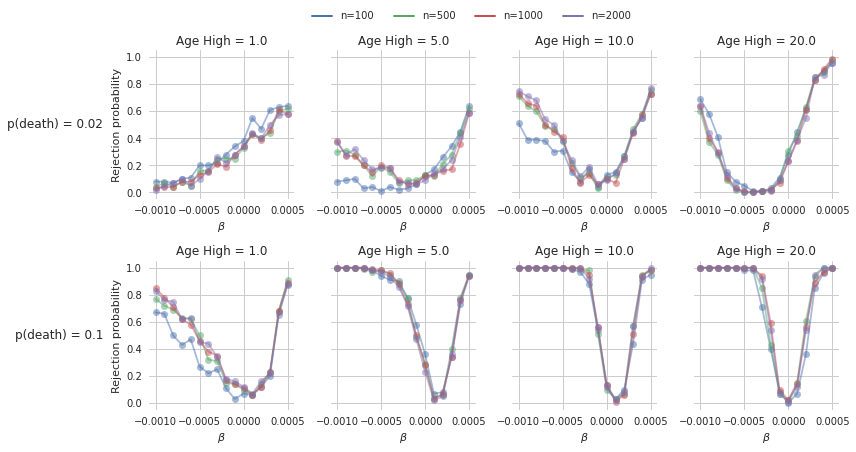

In [481]:
import pandas as pd


fig, axes = plt.subplots(ncols=4, nrows=2, sharey=True, figsize=(12, 6))

for j, n in enumerate((100, 500, 1000, 2000)):
    transform = Compose(Sampler(n=n), HillNumbers(q_step=0.25))
    testdata = PresimulatedDataset.load(
        "../data/scenario-2-testset.npz", transform=transform)

    for i, p_death in enumerate((0.02, 0.1)):

        X_test, theta_test = testdata.dataset.numpy(), testdata.theta.numpy()
        y_test = (theta_test[:, 0] != 0).astype(int)
        
        index = (theta_test[:, 2] == p_death)
        
        X_test, y_test = X_test[index], y_test[index]


        probs = models_2[n]["clf"].predict_proba(X_test)[:, 1]
        pred = (probs > 0.5).astype(float)

        df = pd.DataFrame(theta_test[index], columns=["b", "p_mut", "p_death", "age_max"])
        df["pred"] = pred
        for k, (age, g) in enumerate(df.groupby("age_max")):
            g = g.groupby("b")["pred"].mean()
            axes[i, k].plot(g.index, g.values, '-o', color=f"C{j}", alpha=0.5)
            axes[i, k].set(xlabel="$\\beta$", title=f"Age High = {age}")
    
        axes[i, 0].set(ylabel="Rejection probability")

rows = [f'p(death) = {v}' for v in (0.02, 0.1)]
pad = 5
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
custom_lines = [Line2D([0], [0], color="C0", lw=2),
                Line2D([0], [0], color="C1", lw=2),
                Line2D([0], [0], color="C2", lw=2),
                Line2D([0], [0], color="C3", lw=2)]
fig.legend(custom_lines, ['n=100', 'n=500', 'n=1000', 'n=2000'], 
          loc="upper center", ncol=4, bbox_to_anchor=(0.55, 1.05), frameon=False)

plt.tight_layout()
plt.savefig("../plots/scenario3-rejection.png", 
            transparent=True, dpi=300, bbox_inches='tight')

In [1]:
%run ../src/simulation.py

In [4]:
model = Simulator(p_death=0.1, earlystopper="diversity")

In [5]:
model.fit()

<IPython.core.display.Javascript object>

Burn-in period: 23750it [04:32, 87.18it/s]


In [1294]:
from sklearn.metrics import auc

area = [auc(hill.q, r) for r in results]

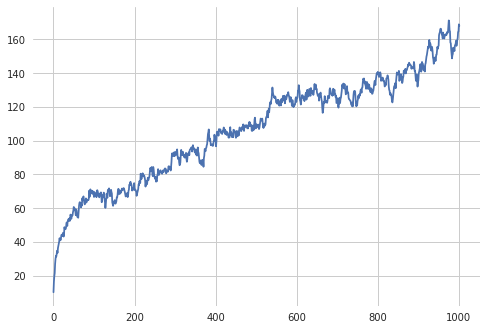

In [1295]:
plt.plot(area)

In [1301]:
from jupyterplot import ProgressPlot
import numpy as np


for i in range(1000):
    pp.update(np.sin(i / 100))
pp.finalize()

In [1347]:
import tqdm
from sklearn.metrics import auc


n_agents = 100_000

m1 = Simulator(n_agents, timesteps=1, restricted_age_window=True)
m2 = Simulator(n_agents, timesteps=1, restricted_age_window=True)

hill = HillNumbers(max_q=5, q_step=0.25)

pop1 = np.random.choice(2, size=n_agents)
pop2 = np.random.choice(int(n_agents / 10), size=n_agents)

bd1 = np.ceil(np.random.random(n_agents) * 50).astype(np.int64)
bd2 = np.ceil(np.random.random(n_agents) * 50).astype(np.int64)

t1 = len(np.unique(pop1))
t2 = len(np.unique(pop2))

pp = ProgressPlot(y_lim=[0, 40], line_names=["pop1", "pop2"])

for timestep in tqdm.trange(100_000):
    pop1, bd1, t1, _ = m1._get_dynamics(
        timestep, -0.001, 0.0005, 0.02, 20, pop1, bd1, t1
    )
    pop2, bd2, t2, _ = m2._get_dynamics(
        timestep, -0.001, 0.0005, 0.02, 20, pop2, bd2, t2
    )
    
    if timestep > 10 and timestep % 10 == 0:
        x1 = np.bincount(reindex_array(pop1))[:, None][:, 0]
        x1 = hill(x1)[0]
#         x = Evenness()(x)[0]
#         auc1 = auc(hill.q, x)
        
        x2 = np.bincount(reindex_array(pop2))[:, None][:, 0]
        x2 = hill(x2)[0]
#         x = Evenness()(x)[0]
#         auc2 = auc(hill.q, x)
        pp.update([[x1[-1], x2[-1]]])

<IPython.core.display.Javascript object>

 19%|█▉        | 19432/100000 [02:48<11:37, 115.56it/s]


KeyboardInterrupt: 

In [1337]:
x1[-1], x2[-1]

(34.76022652571642, 21.015918907741668)

In [1309]:
x

array([1.        , 0.31978963, 0.11000268, 0.05035491, 0.03038931,
       0.02209349, 0.01800643, 0.01572499, 0.01432673, 0.01340597,
       0.01276444, 0.01229673, 0.0119429 , 0.01166691, 0.01144604,
       0.01126542, 0.01111497, 0.01098764, 0.01087841, 0.01078357,
       0.01070036])

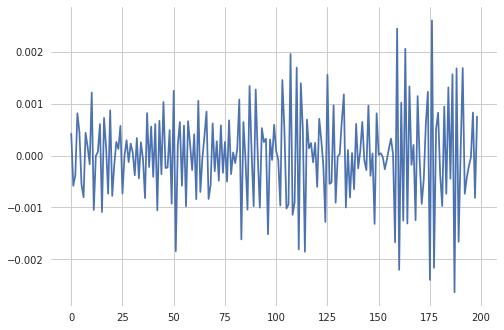

In [1281]:
plt.plot(earlystopper.Y)

In [1282]:
results = np.array(results)
results = np.squeeze(results, 1)

In [1284]:
breakpoints

[2020,
 2030,
 2040,
 2050,
 2060,
 2070,
 2080,
 2090,
 2100,
 2110,
 2120,
 2130,
 2140,
 2150,
 2160,
 2170,
 2180,
 2190,
 2200,
 2210,
 2220,
 2230,
 2240,
 2250,
 2260,
 2270,
 2280,
 2290,
 2300,
 2310,
 2320,
 2330,
 2340,
 2350,
 2360,
 2370,
 2380,
 2390,
 2400,
 2410,
 2420,
 2430,
 2440,
 2450,
 2460,
 2470,
 2480,
 2490,
 2500,
 2510,
 2520,
 2530,
 2540,
 2550,
 2560,
 2570,
 2580,
 2590,
 2600,
 2610,
 2620,
 2630,
 2640,
 2650,
 2660,
 2670,
 2680,
 2690,
 2700,
 2710,
 2720,
 2730,
 2740,
 2750,
 2760,
 2770,
 2780,
 2790,
 2800,
 2810,
 2820,
 2830,
 2840,
 2850,
 2860,
 2870,
 2880,
 2890,
 2900,
 2910,
 2920,
 2930,
 2940,
 2950,
 2960,
 2970,
 2980,
 2990,
 3000,
 3010,
 3020,
 3030,
 3040,
 3050,
 3060,
 3070,
 3080,
 3090,
 3100,
 3110,
 3120,
 3130,
 3140,
 3150,
 3160,
 3170,
 3180,
 3190,
 3200,
 3210,
 3220,
 3230,
 3240,
 3250,
 3260,
 3270,
 3280,
 3290,
 3300,
 3310,
 3320,
 3330,
 3340,
 3350,
 3360,
 3370,
 3380,
 3390,
 3400,
 3410,
 3420,
 3430,
 3440,

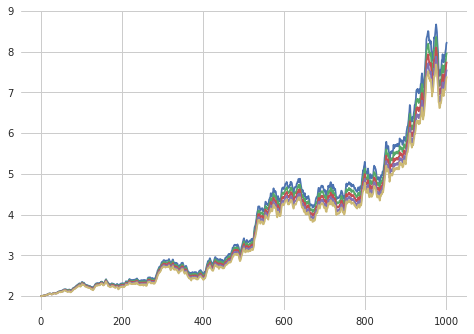

In [1283]:
plt.plot(results[:, -5:])

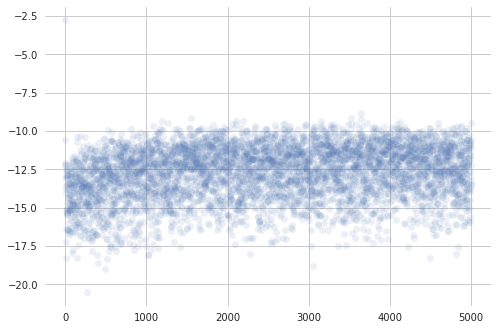

In [1199]:
plt.plot(np.log(results[::10]), 'o', alpha=0.1)

In [1244]:
results[:, -4:][-10:]

array([[27.57850714, 26.88378464, 26.26515089, 25.71099242],
       [27.66065919, 26.97482619, 26.36452983, 25.81820552],
       [27.59917001, 26.90988675, 26.29648477, 25.74735747],
       [27.73401327, 27.04175231, 26.42553279, 25.87375218],
       [27.72713659, 27.03621263, 26.42138913, 25.87105542],
       [27.72815067, 27.03780126, 26.42323252, 25.87291311],
       [27.77966859, 27.08613332, 26.46814662, 25.91424945],
       [27.76135478, 27.062461  , 26.43945502, 25.88084172],
       [27.75312448, 27.05861319, 26.43960116, 25.88465737],
       [27.80856384, 27.1144992 , 26.49603645, 25.94172815]])

In [1245]:
import scipy.spatial.distance as D

dm = D.squareform(D.pdist(results[:, -4:], metric="euclidean"))

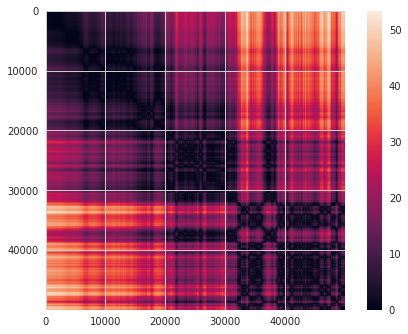

In [1246]:
import scipy.stats as stats

plt.imshow(dm)
plt.colorbar()

In [1209]:
dm.shape

(50000, 50000)

In [1252]:
results = np.array(results)
results = np.squeeze(results, 1)

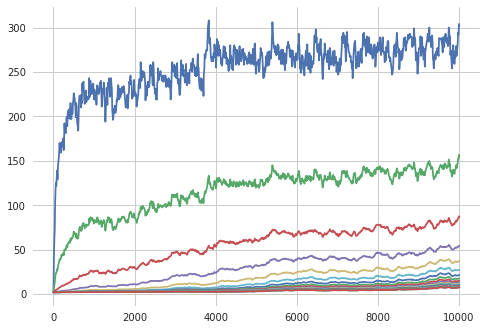

In [1285]:
for i in range(0, results.shape[1]):
    plt.plot(np.arange(0, len(results[:, i]) * 10, 10), results[:, i])

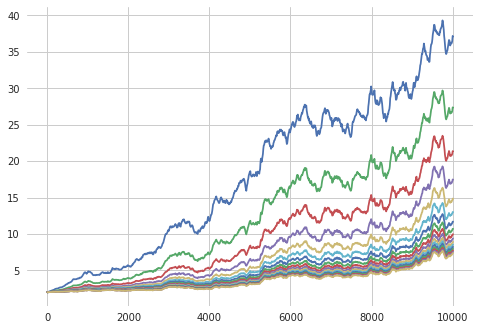

In [1286]:
for i in range(4, results.shape[1]):
    plt.plot(np.arange(0, len(results[:, i]) * 10, 10), results[:, i])

Question: why is $p(death) = 0.02$ so much harder than $p(death) = 0.1$. Less variation in the statistics?

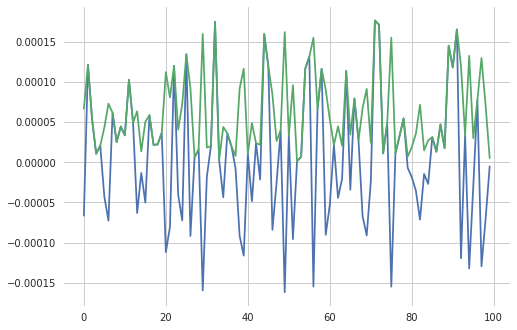

In [1122]:
plt.plot(earlystopper.dists)
plt.plot(np.abs(np.array(earlystopper.dists)))

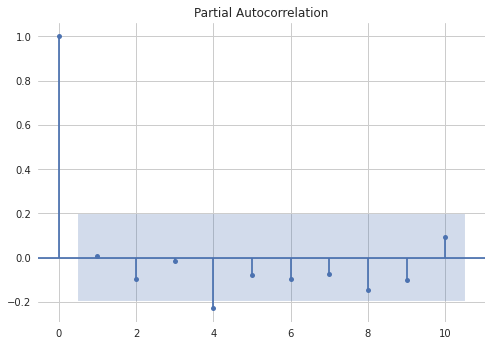

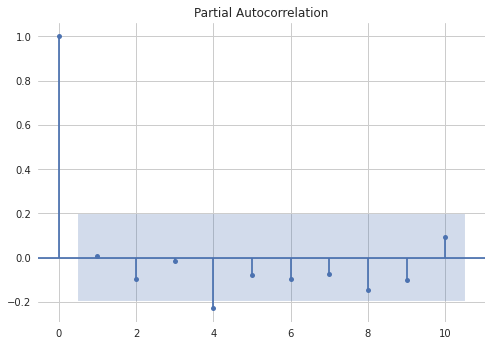

In [1124]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(earlystopper.dists, lags = 10)

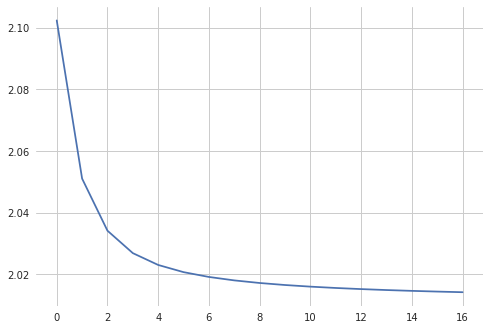

In [911]:
plt.plot(results[10][4:])

In [769]:
((Evenness()(results[2000]) - Evenness()(results[3000])) ** 2).mean()

0.00030573873986336687

In [774]:
m = Simulator(100_000, warmup=10000, timesteps=1)
x = m((0.0, 0.0005, 0.1, 10))
x

Generating populations: 100%|██████████| 1/1 [00:00<00:00, 181.26it/s]


array([[30641],
       [35732],
       [ 1596],
       [  803],
       [ 1056],
       [  480],
       [ 1694],
       [  979],
       [   88],
       [  365],
       [ 1012],
       [  496],
       [  629],
       [  215],
       [  395],
       [ 1659],
       [  181],
       [   50],
       [ 1136],
       [   21],
       [  122],
       [ 1440],
       [   15],
       [  303],
       [ 1182],
       [  357],
       [ 1002],
       [  151],
       [  111],
       [   86],
       [  606],
       [  509],
       [  549],
       [  558],
       [   16],
       [   24],
       [  680],
       [   44],
       [   51],
       [   46],
       [  265],
       [   13],
       [   49],
       [  243],
       [   54],
       [   15],
       [  511],
       [  139],
       [  336],
       [   49],
       [  152],
       [  123],
       [  467],
       [   96],
       [  153],
       [  500],
       [   71],
       [   86],
       [  162],
       [  262],
       [  296],
       [  238],
       [

In [784]:
import statsmodels.tsa.stattools as sts

In [997]:
from arch.unitroot import ZivotAndrews, ADF

ZivotAndrews(earlystopper.dists)

Test Statistic,-13.132
P-value,0.000
Lags,0


In [1006]:
ADF(np.diff(np.random.random(1000) + np.arange(1000)))

Test Statistic,-11.488
P-value,0.000
Lags,22


Ttest_1sampResult(statistic=76.19239977196206, pvalue=0.0)


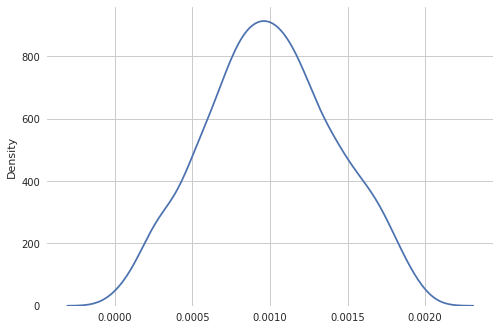

In [1067]:
x = np.random.random(1000) + np.arange(0, 1000)
x = (x - x.min()) / (x.max() - x.min())
sns.kdeplot(np.diff(x))
print(stats.ttest_1samp(np.diff(x), 0))

In [1068]:
Y = np.zeros(1000 - 1)
for i in range(1, 1000):
    Y[i - 1] = (x[i] - x[i - 1]) / np.sqrt(
        2 * x[i - 1] * (1 - x[i - 1])
    )

# sns.kdeplot(Y[1:])
print(stats.ttest_1samp(Y[1:], 0))

Ttest_1sampResult(statistic=35.55413339841376, pvalue=1.7778144417085022e-179)


<ipython-input-1068-a81ecfd067c2>:3: RuntimeWarning: divide by zero encountered in double_scalars
  Y[i - 1] = (x[i] - x[i - 1]) / np.sqrt(


In [1084]:
x.mean()

0.500386983640011

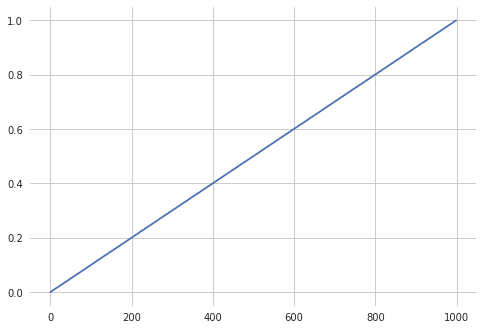

In [1069]:
plt.plot(x)

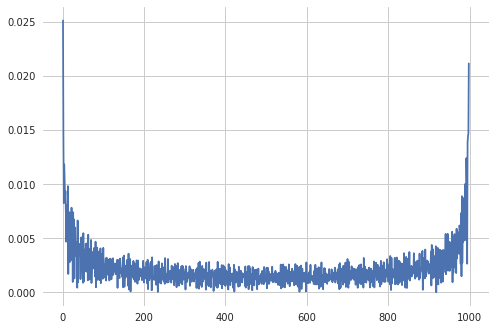

In [1070]:
plt.plot(Y)

In [1082]:
stats.ttest_1samp(stats.zscore(np.diff(x, 1)), 0)

Ttest_1sampResult(statistic=7.232313321865443e-16, pvalue=0.9999999999999994)

In [1026]:
stats.ttest_1samp??

In [1025]:
ADF(np.diff(x))

Test Statistic,-12.268
P-value,0.000
Lags,21
